<a href="https://colab.research.google.com/github/anko191/Python_Kaggle/blob/master/Feature_Engineering/Feature_Engineering_Feature_Generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 特徴量を作成します
* カテゴリ機能を使用して新しい機能を作成する方法
* 生成された数値機能のいくつかの例を見ることが出来ます

In [1]:
# %matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters() # エラー防止なだけ
from sklearn.preprocessing import LabelEncoder

ks = pd.read_csv('/content/ks-projects-201801.csv', parse_dates = ['deadline', 'launched'])

# Drop live projects
ks = ks.query('state != "live"')

# Add outcome column, "successful" == 1 , others are 0
ks = ks.assign(outcome = (ks['state'] == 'successful').astype(int))

# Timestamp features
ks = ks.assign(hour = ks.launched.dt.hour,
               day = ks.launched.dt.day,
               month=ks.launched.dt.month,
               year=ks.launched.dt.year)

# Label encoding
cat_features = ['category', 'currency', 'country']
encoder = LabelEncoder()
encoded = ks[cat_features].astype(str).apply(encoder.fit_transform)

data_cols = ['goal', 'hour', 'day', 'month', 'year', 'outcome']
baseline_data = ks[data_cols].join(encoded)

## Interactions(相互作用)
* もっとも簡単な一つは、カテゴリ変数を組み合わせることです。
    * 例えば、1つのレコードが国"CA"とカテゴリ"Music"を持つ場合、新しい値を作成することが出来ます。
    * これは、カテゴリ変数間の**相関関係**に関する情報を提供することが出来ます。
* 一般的には、カテゴリ特徴量の**すべてのペアから相互作用特徴量**を作成します。
* Pandasでは、通常のPythonの文字列の様に文字列の列を単純に追加することが出来ます。

In [2]:
interactions = ks['category'] + "_" + ks['country']
interactions.head(5)

0            Poetry_GB
1    Narrative Film_US
2    Narrative Film_US
3             Music_US
4      Film & Video_US
dtype: object

* そして、相互作用の特徴をラベルでエンコードし、データに追加することが出来ます。

In [3]:
label_enc = LabelEncoder()
data_interaction = baseline_data.assign(category_country = label_enc.fit_transform(interactions))
data_interaction.head()

,goal,hour,day,month,year,outcome,category,currency,country,category_country
0,1000.0,12,11,8,2015,0,108,5,9,1900
1,30000.0,4,2,9,2017,0,93,13,22,1630
2,45000.0,0,12,1,2013,0,93,13,22,1630
3,5000.0,3,17,3,2012,0,90,13,22,1595
4,19500.0,8,4,7,2015,0,55,13,22,979


* 練習問題では全部のペアについて相互作用を作成するぞ

## 直近の1週間のプロジェクト数をカウントする
各レコードについて、
* **その前の週**に立ち上げられたプロジェクト数をカウント
* .rollingメソッドを使って、時間でソートした後に、時間とか、日とか週で定義できる

In [4]:
launched = pd.Series(ks.index, index = ks.launched, name = "count_7_days").sort_index()
launched.head(20)

launched
1970-01-01 01:00:00     94579
1970-01-01 01:00:00    319002
1970-01-01 01:00:00    247913
1970-01-01 01:00:00     48147
1970-01-01 01:00:00     75397
1970-01-01 01:00:00      2842
1970-01-01 01:00:00    273779
2009-04-21 21:02:48    169268
2009-04-23 00:07:53    322000
2009-04-24 21:52:03    138572
2009-04-25 17:36:21    325391
2009-04-27 14:10:39    122662
2009-04-28 13:55:41    213711
2009-04-29 02:04:21    345606
2009-04-29 02:58:50    235255
2009-04-29 04:37:37     98954
2009-04-29 05:26:32    342226
2009-04-29 06:43:44    275091
2009-04-29 13:52:03    284115
2009-04-29 22:08:13     32898
Name: count_7_days, dtype: int64

明らかに発売日が間違っているプロジェクトがありますが、...ここでは無視<br>
* 時系列データでは、
    * .rollingを使って期間をウインドウとして選択することが出来ます。
    * 例えば、launched.rolling('7d')は、過去7日間のすべてのデータを含むのを作成
    * 現在のプロジェクトはカウントしたくない場合は1を引く必要があります。

In [11]:
count_7_days = launched.rolling('7d').count() - 1
print(count_7_days.head(20))

launched
1970-01-01 01:00:00     0.0
1970-01-01 01:00:00     1.0
1970-01-01 01:00:00     2.0
1970-01-01 01:00:00     3.0
1970-01-01 01:00:00     4.0
1970-01-01 01:00:00     5.0
1970-01-01 01:00:00     6.0
2009-04-21 21:02:48     0.0
2009-04-23 00:07:53     1.0
2009-04-24 21:52:03     2.0
2009-04-25 17:36:21     3.0
2009-04-27 14:10:39     4.0
2009-04-28 13:55:41     5.0
2009-04-29 02:04:21     5.0
2009-04-29 02:58:50     6.0
2009-04-29 04:37:37     7.0
2009-04-29 05:26:32     8.0
2009-04-29 06:43:44     9.0
2009-04-29 13:52:03    10.0
2009-04-29 22:08:13    11.0
Name: count_7_days, dtype: float64


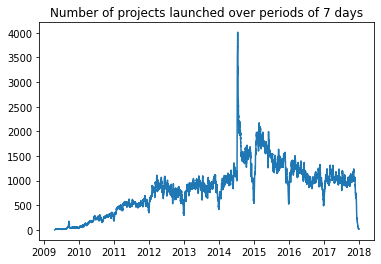

In [12]:
# Ignore records with broken launch dates
plt.plot(count_7_days[7:]);
plt.title("Number of projects launched over periods of 7 days");

## では、カウントが得られたので、
* 他の学習データと結合できるように**インデックスを調節する**必要があります。

In [13]:
print(count_7_days.head(5))
count_7_days.index = launched.values
print(count_7_days.head(5))
count_7_days = count_7_days.reindex(ks.index)

launched
1970-01-01 01:00:00    0.0
1970-01-01 01:00:00    1.0
1970-01-01 01:00:00    2.0
1970-01-01 01:00:00    3.0
1970-01-01 01:00:00    4.0
Name: count_7_days, dtype: float64
94579     0.0
319002    1.0
247913    2.0
48147     3.0
75397     4.0
Name: count_7_days, dtype: float64


In [21]:
count_7_days.value_counts()

1040.0    683
1041.0    678
1037.0    674
1042.0    661
1036.0    654
         ... 
3482.0      1
3071.0      1
3073.0      1
3048.0      1
3063.0      1
Name: count_7_days, Length: 4013, dtype: int64

## joinを使って他のデータと新しい機能を結合しましょう

In [18]:
baseline_data.join(count_7_days).head(10)

,goal,hour,day,month,year,outcome,category,currency,country,count_7_days
0,1000.0,12,11,8,2015,0,108,5,9,1409.0
1,30000.0,4,2,9,2017,0,93,13,22,957.0
2,45000.0,0,12,1,2013,0,93,13,22,739.0
3,5000.0,3,17,3,2012,0,90,13,22,907.0
4,19500.0,8,4,7,2015,0,55,13,22,1429.0
5,50000.0,13,26,2,2016,1,123,13,22,1284.0
6,1000.0,18,1,12,2014,1,58,13,22,1119.0
7,25000.0,20,1,2,2016,0,41,13,22,1391.0
8,125000.0,18,24,4,2014,0,113,13,22,1043.0
9,65000.0,21,11,7,2014,0,39,13,22,3199.0


# 同じカテゴリーの最後のプロジェクトからの時間
* 同じカテゴリーのプロジェクトがドナーを競う？ビデオゲームに資金を提供しようとしていて、別のゲームプロジェクトが立ち上がったばかりの場合、同じように多くの資金を得られない可能性があります。
* 同じカテゴリーのプロジェクトが最後に立ち上がってからの時間を計算することで、これを捉えることができます。
* .groupbyの後に、.transformを使用する
    * .transformの中身に関数を渡して、なんか楽しいことが出来る

In [22]:
def time_since_last_project(series):
    # Return the time in hours
    return series.diff().dt.total_seconds() / 3600.
print(ks['category'])
df = ks[['category', 'launched']].sort_values('launched')
timedeltas = df.groupby('category').transform(time_since_last_project)
timedeltas.head(20)

0                  Poetry
1          Narrative Film
2          Narrative Film
3                   Music
4            Film & Video
               ...       
378656        Documentary
378657     Narrative Film
378658     Narrative Film
378659         Technology
378660    Performance Art
Name: category, Length: 375862, dtype: object


,launched
94579,NaN
319002,NaN
247913,NaN
48147,NaN
75397,NaN
2842,0.000000
273779,NaN
169268,NaN
322000,NaN
138572,NaN


## NaNのデータがあるので、、
* 平均値や中央値のようなもので埋める必要があります。また、他のデータと結合できるように、インデックスをリセットする必要があります

In [23]:
timedeltas = timedeltas.fillna(timedeltas.median()).reindex(baseline_data.index)
timedeltas.head(20)

,launched
0,18.606111
1,5.592778
2,1.313611
3,0.635000
4,16.661389
5,2.629722
6,0.367500
7,12.286111
8,14.243611
9,0.174722


# 数値変換
* ゴールの分布を見てみましょう

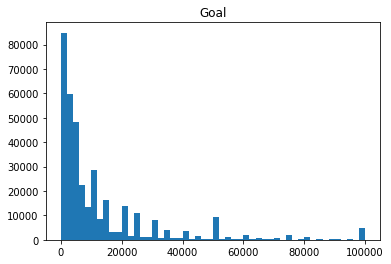

In [27]:
plt.hist(ks.goal, bins = 50, range = (0, 100000));
plt.title('Goal');

Text(0.5, 1.0, 'Sqrt(Goal)')

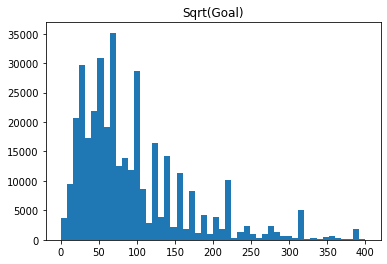

In [28]:
plt.hist(np.sqrt(ks.goal), range=(0,400), bins=50);
plt.title('Sqrt(Goal)')

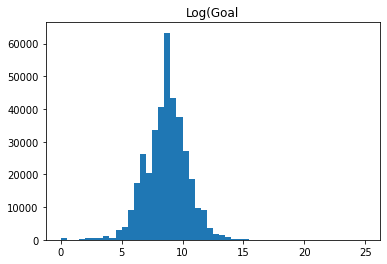

In [29]:
plt.hist(np.log(ks.goal), range=(0,25), bins = 50);
plt.title('Log(Goal');

### ほとんどのプロジェクトが5000ドル以下のゴールを持っていることが分かる。
* しかし、10万どるまでのゴールのロングテールがある
* いくつかのモデルは、特徴が**正規分布**しているときにうまく機能するので、
    * ゴール値を変換するのに役立つかもしれません。
    * これには、**平方根と自然対数**が良く使われます。
    * これらの変換は、外れ値を制約するのにも役立ちます。
    

### しかし、、
* 木ベースのモデルはスケール不変なので、対数変換は我々のモデルの助けにはなりません
* しかし、線形モデルやニューラルネットワークがあればこれは役立つはずでsう

### 他の変換には、2乗や他の累乗、指数があります。。
* これらはSVMのカーネルトリックのように、モデルの識別に役立つかもしれません。
* 繰り返しになりますが、何が有効かを確認するには少し実験が必要です。
* 一つの方法は、新しい特徴量の束を作成し、後で特徴量アルゴリズムの使って最適なものを選択することです。

In [ ]:
import numpy as np
import pandas as pd
from sklearn import preprocessing, metrics
import lightgbm as lgb

# Set up code checking
from learntools.core import binder
binder.bind(globals())
from learntools.feature_engineering.ex3 import *

# Create features from   timestamps
click_data = pd.read_csv('../input/feature-engineering-data/train_sample.csv', 
                         parse_dates=['click_time'])
click_times = click_data['click_time']
clicks = click_data.assign(day=click_times.dt.day.astype('uint8'),
                           hour=click_times.dt.hour.astype('uint8'),
                           minute=click_times.dt.minute.astype('uint8'),
                           second=click_times.dt.second.astype('uint8'))

# Label encoding for categorical features
cat_features = ['ip', 'app', 'device', 'os', 'channel']
for feature in cat_features:
    label_encoder = preprocessing.LabelEncoder()
    clicks[feature] = label_encoder.fit_transform(clicks[feature])
    
def get_data_splits(dataframe, valid_fraction=0.1):

    dataframe = dataframe.sort_values('click_time')
    valid_rows = int(len(dataframe) * valid_fraction)
    train = dataframe[:-valid_rows * 2]
    # valid size == test size, last two sections of the data
    valid = dataframe[-valid_rows * 2:-valid_rows]
    test = dataframe[-valid_rows:]
    
    return train, valid, test

def train_model(train, valid, test=None, feature_cols=None):
    if feature_cols is None:
        feature_cols = train.columns.drop(['click_time', 'attributed_time',
                                           'is_attributed'])
    dtrain = lgb.Dataset(train[feature_cols], label=train['is_attributed'])
    dvalid = lgb.Dataset(valid[feature_cols], label=valid['is_attributed'])
    
    param = {'num_leaves': 64, 'objective': 'binary', 
             'metric': 'auc', 'seed': 7}
    num_round = 1000
    print("Training model. Hold on a minute to see the validation score")
    bst = lgb.train(param, dtrain, num_round, valid_sets=[dvalid], 
                    early_stopping_rounds=20, verbose_eval=False)
    
    valid_pred = bst.predict(valid[feature_cols])
    valid_score = metrics.roc_auc_score(valid['is_attributed'], valid_pred)
    print(f"Validation AUC score: {valid_score}")
    
    if test is not None: 
        test_pred = bst.predict(test[feature_cols])
        test_score = metrics.roc_auc_score(test['is_attributed'], test_pred)
        return bst, valid_score, test_score
    else:
        return bst, valid_score

print("Baseline model score")
train, valid, test = get_data_splits(clicks)
_ = train_model(train, valid)

## 相互作用の特徴を加えましょう
ここでは、各ペアに対して、interaction機能を追加
* 特徴のペアを反復処理する最も簡単な方法は、itertools.combinationsを使うことです。
* 値をアンダースコア付きの文字列として結合します。
* データセットに新しい列を追加する際には、値をラベルでエンコードするようにしてください

In [ ]:
import itertools

cat_features = ['ip', 'app', 'device', 'os', 'channel']
interactions = pd.DataFrame(index=clicks.index)

# Iterate through each pair of features, combine them into interaction features
for col1, col2 in itertools.combinations(cat_features, 2):
    new_col_name = '_'.join([col1,col2])
    
    # Convert to strings and combine
    new_values = clicks[col1].map(str) + "_" + clicks[col2].map(str)
    
    encoder = preprocessing.LabelEncoder()
    interactions[new_col_name] = encoder.fit_transform(new_values)


In [ ]:
clicks = clicks.join(interactions)
print("Score with interactions")
train, valid, test = get_data_splits(clicks)
_ = train_model(train, valid)

## 数値特徴量の作成
新しい数値的特徴を作成するのも効果的で、通常はモデルに多くの改善が得られます
* すこし、ブレインストーミングと実験が必要

* 過去6時間の同じIPからのイベント数
    * 頻繁に訪問している人がアプリをダウンロードする可能性が高いです
* クリック時間(timestamp)の系列を取得し、過去6時間のイベント数を含む別の系列を返す関数count_past_eventsを実装します。
* ローリングメソッドが便利です。

In [ ]:
def count_past_events(series, time_window = '6H'):
    series = pd.Series(series.index, index = series)
    past_events = series.rolling(time_window).count()-1
    return past_events

これくそ時間かかるので気を付けて

In [ ]:
clicks['ip_past_6hr_counts'] = past_events
train, valid, test = get_data_splits(clicks)
_ = train_model(train, valid)

### 今後の情報からの特
* 過去の出来事を見る機能を作った
* また、未来のイベントの情報を利用する機能を作ることもできます。
    * 未来のイベントを使うべきか、使わないべきか?
    * **一般的には、使うべきではありません**。
    * このようなモデルを実世界のしなりをで使用する場合、未来からのデータはありません。
    * あなたのモデルのスコアは、過去のデータでトレーニングしてテストすると、おそらく高くなりますが、実際のデータでのパフォーマンスを過大評価することになります。
    * 未来のデータを使用することで、Kaggleの競争テストデータでのスコアが向上することに注意すべきですが、機械学習製品を構築する際には避けたほうが良いでしょう。
    

## 前回のイベントからの時間
タイムスタンプの系列から最後のイベントからの時間を秒単位で計算する関数time_diffを実装し明日。

In [ ]:
def time_diff(series):
    """Returns a series with the time since the last timestamp in seconds."""
    return series.diff().dt.total_seconds()


In [ ]:
clicks['past_events_6hr'] = past_events

train, valid, test = get_data_splits(clicks.join(past_events))
_ = train_model(train, valid)

## 過去のアプリのダウンロード数
* 訪問者が以前にアプリをダウンロードした場合、その訪問者が再びアプリをダウンロードする可能性に影響を与える可能性があります。
* 現在のイベントの前にアプリがダウンロードされた回数('is_attributed' == 1)の系列を返す関数previous_attributionsを実装します


In [ ]:
def previous_attributions(series):
    """Returns a series with the number of times an app has been downloaded."""
    sums = series.expanding(min_periods = 2).sum() - series
    return sums


* ここでは、常に最初の行から始まり、データの中に入っていくにつれて拡張されるウィンドウが欲しいとします。
* これには .expanding メソッドを使用できます。また、現在の行はウィンドウに含まれているので、それを差し引く必要があります。

In [ ]:
clicks['ip_past_6hr_counts'] = past_events

train, valid, test = get_data_splits(clicks)
_ = train_model(train, valid)

## これまでは木ベースのLightGBMを使用している。
これらは、ニューラルネットワークにも有効なのかな？
* 特徴量自体はどちらのモデルでも機能します。
* しかし、ニューラルネットワークへの数値入力は、最初に標準化する必要があります。
* これは、sklearn.preprocessing.StandardScalerを使って行うことが出来ます。

* さまざまな特徴の束を生成したので、モデルのサイズを小さくしてパフォーマンスを向上させるために、
    * **一般的にはそれらのうちのいくつかを削除したいと思うでしょう。**